# HA-ES Plotting

- udpated version of plotting script used for paper "..."

## General

- imports
- defintions
- loading data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmo as pg
import seaborn as sns

import math
import os

from autorank._util import get_sorted_rank_groups
from autorank import autorank, plot_stats
from tabrepo import load_repository

method_id_name_dict = {
    "GES": "GES*",
    "SINGLE_BEST": "Single-Best",
    "QO": "QO-ES",
    "QDO": "QDO-ES",
    "ENS_SIZE_QDO": "Ensemble Size",
    #"INFER_TIME_QDO": "Inference Time",
    "INFER_TIME_QDO": "HAPEns",
    "MEMORY_QDO": "Memory",
    "DISK_QDO": "Diskspace",
}
infer_time_weights = np.linspace(0, 1, num=20)[1:]
infer_time_weights = np.round(infer_time_weights, 2)
multi_ges_method_ids = [f"MULTI_GES-{time_weight:.2f}" for time_weight in infer_time_weights]
multi_ges_method_names = [f"Multi-GES({time_weight:.2f})" for time_weight in infer_time_weights]
for id, name in zip(multi_ges_method_ids, multi_ges_method_names):
    method_id_name_dict[id] = name

print("Loading data. This might take a while...")
df = pd.read_csv("../data/full-mges.csv")

# Map method IDs to names
if "method" in df.columns:
    df["method_name"] = df["method"].map(method_id_name_dict)
else:
    raise ValueError("Column 'method' not found in DataFrame")
df = df.dropna(subset=['method_name'])
print(df.shape)
print(df.columns)
print(df["method_name"].unique())
print(df["method"].unique())

df["models_used_length"] = df["models_used"].apply(len)

if False:
    print("Filtering methods...")
    filter_methods = [
        "Single-Best",
        "GES*",
        "QDO-ES",
        # "HAPEns",
        # "Memory",
        # "Ensemble Size",
        "HAPEns",
        # "Diskspace",
        "Multi-GES(0.21)",
        "Multi-GES(0.79)"
    ]
    df = df[df['method_name'].isin(filter_methods)]
    print(df.shape)
    print(df.columns)
    print(df["method_name"].unique())
    print(df["method"].unique())

Loading data. This might take a while...
(1488206, 23)
Index(['Unnamed: 0', 'name', 'iteration', 'roc_auc_val', 'roc_auc_test',
       'models_used', 'weights', 'time_weight', 'task', 'dataset', 'fold',
       'method', 'task_id', 'seed', 'inference_time', 'memory', 'diskspace',
       'normalized_roc_auc_val', 'normalized_roc_auc_test', 'normalized_time',
       'normalized_memory', 'normalized_diskspace', 'method_name'],
      dtype='object')
['Multi-GES(0.68)' 'Multi-GES(0.74)' 'Multi-GES(1.00)' 'Multi-GES(0.42)'
 'Multi-GES(0.89)' 'Multi-GES(0.95)' 'Multi-GES(0.53)' 'Multi-GES(0.63)'
 'Multi-GES(0.58)' 'Multi-GES(0.32)' 'Single-Best' 'Multi-GES(0.47)'
 'Multi-GES(0.16)' 'Multi-GES(0.79)' 'Multi-GES(0.05)' 'Multi-GES(0.84)'
 'Multi-GES(0.37)' 'Multi-GES(0.21)' 'GES*' 'Multi-GES(0.26)'
 'Multi-GES(0.11)']
['MULTI_GES-0.68' 'MULTI_GES-0.74' 'MULTI_GES-1.00' 'MULTI_GES-0.42'
 'MULTI_GES-0.89' 'MULTI_GES-0.95' 'MULTI_GES-0.53' 'MULTI_GES-0.63'
 'MULTI_GES-0.58' 'MULTI_GES-0.32' 'SINGLE_

Some initial checks...

In [2]:
single_task_df = df[df['task'] == df['task'].unique()[0]]
print(single_task_df[['normalized_roc_auc_test', 'normalized_time', 'normalized_memory', 'normalized_diskspace']].describe())
df.info()

print("--- Sanity Check: Number of entries per method ---")
entry_counts = df.groupby('method_name').size()
print("Number of entries (solutions) per method:")
print(entry_counts)
print("\\n" + "="*50 + "\\n")


print("--- Sanity Check: Number of unique tasks per method ---")
tasks_per_method = df.groupby('method_name')['task_id'].nunique()
print("Number of unique tasks evaluated per method:")
print(tasks_per_method)
print("\\n" + "="*50 + "\\n")


print("--- Sanity Check: Number of unique seeds per method ---")
seeds_per_method = df.groupby('method_name')['seed'].nunique()
print("Number of unique seeds evaluated per method:")
print(seeds_per_method)
print("\\n" + "="*50 + "\\n")


print("--- Sanity Check: Number of unique folds per method ---")
folds_per_method = df.groupby('method_name')['fold'].nunique()
print("Number of unique folds evaluated per method:")
print(folds_per_method)
print("\\n" + "="*50 + "\\n")

# --- Verification ---
# Check if all methods have the same number of unique tasks, seeds, and folds
all_tasks_consistent = tasks_per_method.nunique() == 1
all_seeds_consistent = seeds_per_method.nunique() == 1
all_folds_consistent = folds_per_method.nunique() == 1

if all_tasks_consistent and all_seeds_consistent and all_folds_consistent:
    print("Verification PASSED: All methods were run on the same number of tasks, seeds, and folds.")
else:
    print("Verification FAILED: There is an inconsistency in the number of tasks, seeds, or folds across methods.")

       normalized_roc_auc_test  normalized_time  normalized_memory  \
count              7202.000000      7202.000000        7202.000000   
mean                  0.037451         0.379565           0.525734   
std                   0.056475         0.220007           0.230309   
min                   0.000000         0.000000           0.000000   
25%                   0.021053         0.192261           0.384615   
50%                   0.028271         0.390947           0.602564   
75%                   0.040301         0.544539           0.692308   
max                   1.000000         1.000000           1.000000   

       normalized_diskspace  
count           7202.000000  
mean               0.595075  
std                0.267559  
min                0.000000  
25%                0.453305  
50%                0.658177  
75%                0.816980  
max                1.000000  
<class 'pandas.core.frame.DataFrame'>
Index: 1488206 entries, 0 to 1628197
Data columns (total 24 c

## Helper Functions

### Boxplot:

In [3]:
import re
import ipywidgets as widgets

def extract_numeric_part(method_name):
    """
    Extracts the numeric part from a method name string. If no numeric part is found, returns None.
    """
    if isinstance(method_name, str):
        match = re.search(r"\((\d*\.?\d+)\)", method_name)
        if match:
            return float(match.group(1))
    return None

def boxplot(
    df: pd.DataFrame,
    y_str: str,
    log_y_scale: bool = False,
    log_x_scale: bool = False,
    flip_y_axis: bool = False,
    orient: str = "v",
    rotation_x_ticks: int = 45,
    outliers=False,
    sort_by_median: bool = True,  # <-- added flag
):
    if y_str not in df.columns:
        raise ValueError(f"Column '{y_str}' not found in DataFrame")
    
    df["method_name"] = df["method_name"].astype(str)

    if sort_by_median:
        # Sort by median of the target column
        medians = (
            df.groupby("method_name")[y_str]
            .median()
            .sort_values(ascending=False)  # largest median first
        )
        df["method_name"] = pd.Categorical(df["method_name"], categories=medians.index, ordered=True)
        df = df.sort_values("method_name")
    else:
        # Alphabetic + numeric sorting as fallback
        df["alphabetic"] = df["method_name"].apply(lambda x: re.split(r"\(\d*\.?\d+\)", x)[0])
        df["numeric"] = df["method_name"].apply(extract_numeric_part)
        df = df.sort_values(by=["alphabetic", "numeric"], ascending=[True, True])
        df = df.drop(columns=["alphabetic", "numeric"])

    plt.figure(figsize=(8, 6))
    if orient == "v":
        sns.boxplot(
            data=df,
            x="method_name",
            y=y_str,
            hue="method_name",
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,
            showfliers=outliers,
        )
    elif orient == "h":
        sns.boxplot(
            data=df,
            x=y_str,
            y="method_name",
            hue="method_name",
            palette="pastel",
            linewidth=2,
            orient=orient,
            legend=False,
            showfliers=outliers,
        )
    else:
        raise ValueError(f"Orient '{orient}' not supported")

    if orient == "v":
        plt.ylabel(y_str)
        plt.xlabel("Ensemble Method")
    else:
        plt.xlabel(y_str)
        plt.ylabel("Ensemble Method")

    if log_y_scale:
        plt.yscale("log")
    if log_x_scale:
        plt.xscale("log")
    if flip_y_axis:
        plt.gca().invert_yaxis()

    plt.xticks(rotation=rotation_x_ticks)
    plt.grid(True)
    plt.tight_layout()

    directory = "../plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(f"{directory}/boxplot_{y_str}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{directory}/boxplot_{y_str}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

def interactive_boxplot(df, column_options):
    y_str_widget = widgets.Dropdown(
        options=column_options,
        description="Y-axis column:",
        style={"description_width": "initial"},
    )
    log_y_scale_widget = widgets.Checkbox(value=False, description="Log-scale Y-axis")
    log_x_scale_widget = widgets.Checkbox(value=False, description="Log-scale X-axis")
    flip_y_axis_widget = widgets.Checkbox(value=False, description="Flip Y-axis")
    orient_widget = widgets.RadioButtons(
        options=["v", "h"],
        value="h",
        description="Orientation:",
        style={"description_width": "initial"},
    )
    rotation_x_ticks_widget = widgets.IntSlider(
        value=0, min=0, max=90, step=5, description="Rotation X-ticks"
    )

    ui = widgets.VBox(
        [
            y_str_widget,
            log_y_scale_widget,
            log_x_scale_widget,
            flip_y_axis_widget,
            orient_widget,
            rotation_x_ticks_widget,
        ]
    )

    out = widgets.interactive_output(
        boxplot,
        {
            "df": widgets.fixed(df),
            "y_str": y_str_widget,
            "log_y_scale": log_y_scale_widget,
            "log_x_scale": log_x_scale_widget,
            "flip_y_axis": flip_y_axis_widget,
            "orient": orient_widget,
            "rotation_x_ticks": rotation_x_ticks_widget,
        },
    )

    display(ui, out)

### Critical Difference:

In [4]:
def cd_evaluation(
    scores,
    maximize_metric=True,
    plt_title="Critical Difference Plot",
    filename="CriticalDifferencePlot.png",
):
    """
    scores: DataFrame with method names as columns and tasks as rows, each cell contains a score value.
    maximize_metric: Boolean, True if higher values are better.
    output_path: Where to save the plot, if None, plot will not be saved.
    plt_title: Title of the plot.
    """
    # Prepare data
    rank_data = -scores if maximize_metric else scores

    # Run autorank
    result = autorank(rank_data, alpha=0.05, verbose=False, order="ascending")

    # Plot with updated font size
    plt.close("all")
    width = 6
    fig, ax = plt.subplots(figsize=(12, width))
    plt.rcParams.update({"font.size": 20})

    plot_stats(result, ax=ax)
    ax.tick_params(axis="both", labelsize=20)  # Set font size for axis ticks
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
    plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

    return result


## Data Exploration

In [5]:
column_options = ["models_used_length", "normalized_roc_auc_test", "normalized_roc_auc_val", "inference_time", "memory", "diskspace", "normalized_memory"]

#filtered_df = df[~df['method_name'].isin(['Multi-GES(0.43)', 'Multi-GES(0.50)'])].copy()
interactive_boxplot(df, column_options)

Output()

/tmp/ipykernel_53796/3407302103.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_df = df.groupby('method_name').agg(


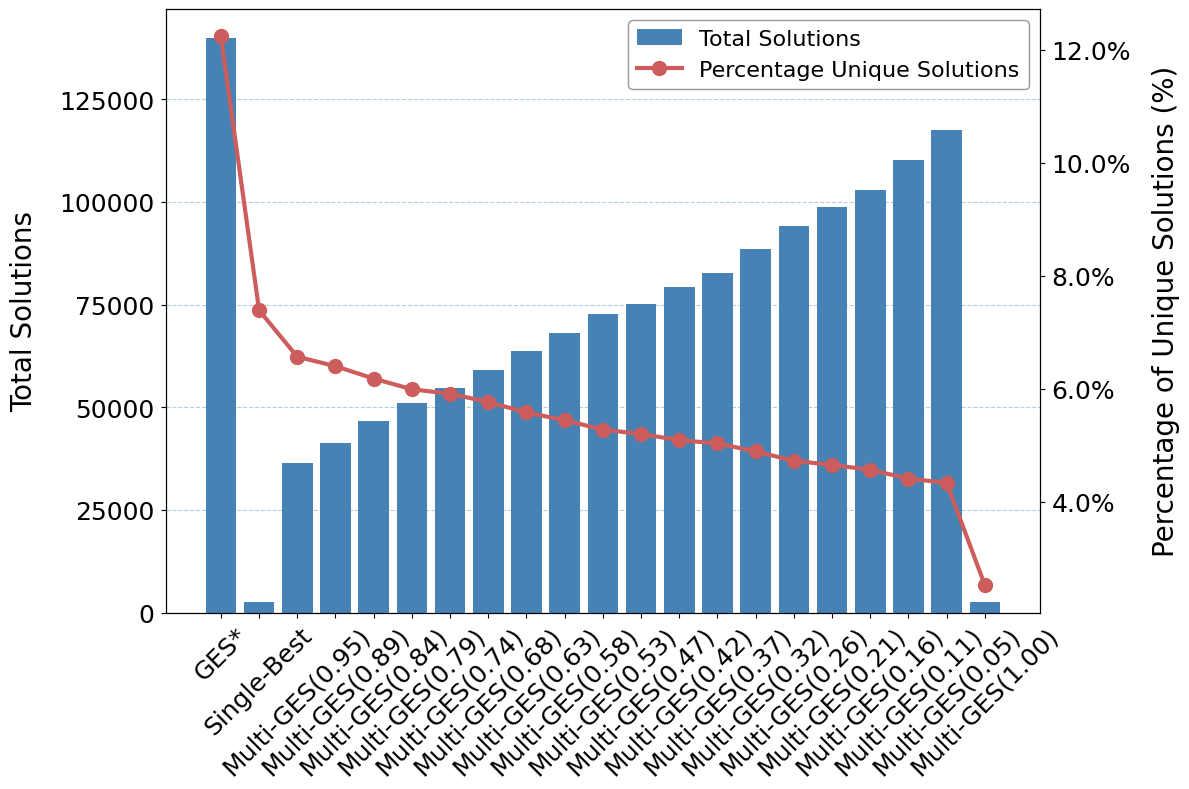

In [6]:
import matplotlib.ticker as mticker
# Group the DataFrame by 'method_name' and compute total and unique counts
result_df = df.groupby('method_name').agg(
    total_solutions=('models_used', 'count'),
    unique_solutions=('models_used', 'nunique')
).reset_index()

# Calculate the percentage of unique solutions
result_df['percentage_unique_solutions'] = (
    result_df['unique_solutions'] / result_df['total_solutions'] * 100
)

# Sort the DataFrame by the percentage of unique solutions for clearer visualization
result_df = result_df.sort_values('percentage_unique_solutions', ascending=False).reset_index(drop=True)


color_total = 'steelblue'
color_unique = 'indianred'
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(result_df['method_name'], result_df['total_solutions'], color=color_total, label='Total Solutions')

# --- Y-axis 1: Total Solutions ---
ax.set_ylabel("Total Solutions", color='black', fontsize=20, labelpad=15)
ax.tick_params(axis='y', labelcolor='black', pad=5, labelsize=18)
ax.grid(axis='y', linestyle='--', color=color_total, alpha=0.4)
ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, integer=True))
ax2 = ax.twinx()
ax2.plot(result_df['method_name'], result_df['percentage_unique_solutions'], color=color_unique, marker='o', linestyle='-', linewidth=3, markersize=10, label='Percentage Unique Solutions')

# --- Y-axis 2: Percentage Unique ---
ax2.set_ylabel('Percentage of Unique Solutions (%)', color='black', fontsize=20, labelpad=15)
ax2.tick_params(axis='y', labelcolor='black', pad=5, labelsize=18)
ax2.grid(False)
ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
ax2.yaxis.set_major_formatter(mticker.PercentFormatter())

# --- Common Settings ---
ax.tick_params(axis='x', rotation=45, labelsize=18)

# --- Legend ---
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(
    lines + lines2,
    labels + labels2,
    loc='upper right',
    fontsize=16,
    frameon=True,
    facecolor='white',
    edgecolor='grey'
)

fig.tight_layout()
plt.savefig("../plots/total-vs-unique-ensembles.png", dpi=300)
plt.savefig("../plots/total-vs-unique-ensembles.pdf", dpi=300)
plt.show()

## Pareto Front Eval

### True Pareto Front

In [7]:
def getParetoFront(df: pd.DataFrame, objectives: list[str], return_mask: bool = False):
    """
    Finds the Pareto-efficient points from a DataFrame.
    
    This function assumes ALL objectives are to be MINIMIZED.

    Args:
        df (pd.DataFrame): DataFrame containing the points.
        objectives (List[str]): List of column names for the objectives.
        return_mask (bool): If True, returns a boolean mask. If False, returns the filtered DataFrame.

    Returns:
        pd.DataFrame or np.ndarray: The Pareto-efficient points or a boolean mask.
    """
    costs = df[objectives].values
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # Find all points not dominated by c
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            # And keep c itself
            is_efficient[i] = True
    
    return is_efficient if return_mask else df[is_efficient]

    
def calculate_pareto_fronts(df, objectives):
    """
    Calculate the Pareto front points for all solutions in the DataFrame per task_id, seed, and fold.

    Parameters:
    - df: pandas DataFrame containing the data.
    - objectives: list of two objective column names.

    Returns:
    - A nested dictionary with structure {task_id: {seed: {fold: pareto_front_df}}}
    """
    if len(objectives) != 2:
        raise ValueError("Exactly two objectives must be provided.")

    # Initialize a dictionary to store the Pareto fronts
    pareto_fronts = {}

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        pareto_fronts[task_id] = {}

        # Iterate over unique seeds
        for seed in df["seed"].unique():
            pareto_fronts[task_id][seed] = {}

            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute Pareto front for df_fold
                is_efficient = getParetoFront(df_fold, objectives, return_mask=True)
                pareto_front_df = df_fold[is_efficient]

                # Store the Pareto front DataFrame
                pareto_fronts[task_id][seed][fold] = pareto_front_df

    return pareto_fronts

In [8]:
from process_data import normalize_data

hw_score = 'hw_score'
perf_metric = 'normalized_roc_auc_test'
hw_metrics = ['normalized_time', 'normalized_memory', 'normalized_diskspace']

df['hw_score'] = df[hw_metrics].mean(axis=1)
for task in df["task"].unique():
    mask = df["task"] == task
    if "hw_score" in df.columns:
        df.loc[mask, "normalized_hw_score"] = normalize_data(
            df.loc[mask, "hw_score"]
        )

metric_pairs = [(perf_metric, hw_metric) for hw_metric in hw_metrics]
metric_pairs.append(('normalized_roc_auc_test', 'hw_score'))
metric_pairs.append(('normalized_roc_auc_test', 'normalized_hw_score'))
print(metric_pairs)

[('normalized_roc_auc_test', 'normalized_time'), ('normalized_roc_auc_test', 'normalized_memory'), ('normalized_roc_auc_test', 'normalized_diskspace'), ('normalized_roc_auc_test', 'hw_score'), ('normalized_roc_auc_test', 'normalized_hw_score')]


### Hypervolume

In [9]:
def calculate_average_hypervolumes(
    df: pd.DataFrame,
    method_name: str,
    perf_metric: str,
    hw_metrics: list[str],
) -> dict:
    print(f"Calculating for HV for {method_name} and metrics {perf_metric} {hw_metrics}")
    all_metrics = [perf_metric] + hw_metrics
    ref_point = [1.01] + [1.01] * len(hw_metrics)

    df_method = df[df["method_name"] == method_name]
    hypervolumes_per_task = {}

    # Iterate over unique task_ids
    for task_id in df_method["task_id"].unique():
        seed_hypervolumes = []  # Store hypervolumes for each seed

        for seed in df_method["seed"].unique():
            fold_hypervolumes = []  # Store hypervolumes for each fold

            for fold in df_method["fold"].unique():
                df_fold = df_method[
                    (df_method["task_id"] == task_id)
                    & (df_method["seed"] == seed)
                    & (df_method["fold"] == fold)
                ]

                if df_fold.empty:
                    continue

                points = df_fold[all_metrics].copy()
                points_to_maximize = points.values
                hv = pg.hypervolume(points_to_maximize)
                hypervolume = hv.compute(ref_point)
                fold_hypervolumes.append(hypervolume)

            # Average hypervolumes across all folds for the current seed
            if fold_hypervolumes:
                average_fold_hypervolume = np.mean(fold_hypervolumes)
                seed_hypervolumes.append(average_fold_hypervolume)

        # Average the seed-level averages for the current task
        if seed_hypervolumes:
            average_seed_hypervolume = np.mean(seed_hypervolumes)
            hypervolumes_per_task[task_id] = average_seed_hypervolume

    return hypervolumes_per_task


def plot_hypervolumes(all_hypervolumes, title: str, directory: str = "../plots/"):
    # Prepare the data for plotting
    methods = list(all_hypervolumes.keys())  # Method names
    hv_values = [list(all_hypervolumes[method].values()) for method in methods]
    data = []

    # Creating a DataFrame suitable for Seaborn
    for method_index, values in enumerate(hv_values):
        for value in values:
            data.append({"Method": methods[method_index], "Hypervolume": value})
    df = pd.DataFrame(data)

    # Calculate medians for each method and sort by median
    median_order = df.groupby("Method")["Hypervolume"].median().sort_values(ascending=False).index

    # Set the figure size and style
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    # Use seaborn's boxplot to plot the DataFrame, ordered by median values
    ax = sns.boxplot(
        y="Method", x="Hypervolume", data=df, hue="Method", palette="Set2",
        orient="h", order=median_order
    )

    # Set titles and labels
    ax.set_ylabel("Method", fontsize=20)
    ax.set_xlabel("Hypervolume", fontsize=20)

    # Set font size for ticks
    ax.tick_params(axis="x", labelrotation=45, labelsize=16)
    ax.tick_params(axis="y", labelsize=16)

    plt.tight_layout()
    plt.savefig(directory + title + ".png", dpi=300)
    plt.savefig(directory + title + ".pdf", dpi=300)
    plt.close()

In [10]:
for perf_metric, hw_metric in metric_pairs:
    methods = df["method_name"].unique()
    all_hypervolumes = {}

    for method in methods:
        all_hypervolumes[method] = calculate_average_hypervolumes(df, method, perf_metric=perf_metric, hw_metrics=[hw_metric])

    # You might want to make this plot function also save to a dynamic filename
    plot_hypervolumes(all_hypervolumes, f"bp_hv_{perf_metric}_{hw_metric}")

    # Create dynamic filenames to avoid overwriting results
    csv_filename = f"../data/hypervolumes_{perf_metric}_{hw_metric}.csv"
    plot_filename_pdf = f"../plots/CDP_HV_{perf_metric}_{hw_metric}.pdf"
    plot_filename_png = f"../plots/CDP_HV_{perf_metric}_{hw_metric}.png"

    hypervolumes_df = pd.DataFrame(all_hypervolumes)
    hypervolumes_df.to_csv(csv_filename, index=False)
    print(f"Saved hypervolume data to {csv_filename}")

    data = []
    for method, task_ids in all_hypervolumes.items():
        for task_id, hypervolume in task_ids.items():
            data.append({"Task": task_id, "Method": method, "Hypervolume": hypervolume})

    df_hypervolumes = pd.DataFrame(data)
    pivot_hypervolumes = df_hypervolumes.pivot(
        index="Task", columns="Method", values="Hypervolume"
    )

    # Run CD evaluation with dynamic filenames
    hv_result = cd_evaluation(
        pivot_hypervolumes,
        maximize_metric=True,
        plt_title=f"Hypervolume CD Plot for {perf_metric} vs {hw_metric}",
        filename=plot_filename_pdf,
    )
    hv_result = cd_evaluation(
        pivot_hypervolumes,
        maximize_metric=True,
        plt_title=f"Hypervolume CD Plot for {perf_metric} vs {hw_metric}",
        filename=plot_filename_png,
    )

print("\n--- Analysis complete for all pairs. ---")

Calculating for HV for Multi-GES(0.68) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.74) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(1.00) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.42) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.89) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.95) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.53) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.63) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.58) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Multi-GES(0.32) and metrics normalized_roc_auc_test ['normalized_time']
Calculating for HV for Single-Best and metrics nor

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


Calculating for HV for Multi-GES(0.68) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.74) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(1.00) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.42) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.89) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.95) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.53) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.63) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.58) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Multi-GES(0.32) and metrics normalized_roc_auc_test ['normalized_memory']
Calculating for HV for Single-

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


Calculating for HV for Multi-GES(0.68) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.74) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(1.00) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.42) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.89) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.95) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.53) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.63) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.58) and metrics normalized_roc_auc_test ['normalized_diskspace']
Calculating for HV for Multi-GES(0.32) and metrics normalized_roc_auc_test ['normalized_diskspace']


/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


Calculating for HV for Multi-GES(0.68) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.74) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(1.00) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.42) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.89) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.95) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.53) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.63) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.58) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.32) and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Single-Best and metrics normalized_roc_auc_test ['hw_score']
Calculating for HV for Multi-GES(0.4

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


Calculating for HV for Multi-GES(0.68) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.74) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(1.00) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.42) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.89) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.95) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.53) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.63) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.58) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculating for HV for Multi-GES(0.32) and metrics normalized_roc_auc_test ['normalized_hw_score']
Calculatin

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank    median       mad  ci_lower  ci_upper  \
Multi-GES(0.37)   8.680723 -0.946013  0.057081 -0.996326 -0.860924   
Multi-GES(0.42)   8.759036 -0.946330   0.05512 -0.996635 -0.864789   
Multi-GES(0.63)   9.234940 -0.951463  0.051158 -0.996625 -0.845191   
Multi-GES(0.68)   9.409639 -0.955721  0.047665 -0.996475 -0.849306   
Multi-GES(0.47)   9.409639 -0.946330  0.056292 -0.996812 -0.854772   
Multi-GES(0.58)   9.433735 -0.946744  0.055013 -0.996595 -0.856704   
Multi-GES(0.32)   9.813253 -0.945571  0.057523 -0.995106 -0.854553   
Multi-GES(0.53)   9.903614 -0.946963  0.055659 -0.996595 -0.845442   
Multi-GES(0.26)   9.951807 -0.941726  0.055369 -0.992158 -0.854026   
Multi-GES(0.74)  10.054217 -0.955721  0.047783  -0.99499 -0.839205   
Multi-GES(0.84)  10.132530 -0.955961   0.05149 -0.991269 -0.842485   
Multi-GES(0.79)  10.283133 -0.957192  0.048409 -0.993642 -0.837454   
Multi-GES(0.21)  10.355422 -0.934730  0.062365  -0.99262 -0.854553   
Multi-GES(0.16)  10.

In [11]:
methods = df["method_name"].unique()
all_hypervolumes = {}

for method in methods:
    all_hypervolumes[method] = calculate_average_hypervolumes(df, method, perf_metric=perf_metric, hw_metrics=hw_metrics)

# You might want to make this plot function also save to a dynamic filename
plot_hypervolumes(all_hypervolumes, f"bp_hv_{perf_metric}_{hw_metric}")

# Create dynamic filenames to avoid overwriting results
csv_filename = f"../data/hypervolumes_{perf_metric}_hw_metrics.csv"
plot_filename_pdf = f"../plots/CDP_HV_{perf_metric}_hw_metrics.pdf"
plot_filename_png = f"../plots/CDP_HV_{perf_metric}_hw_metrics.png"

hypervolumes_df = pd.DataFrame(all_hypervolumes)
hypervolumes_df.to_csv(csv_filename, index=False)
print(f"Saved hypervolume data to {csv_filename}")

data = []
for method, task_ids in all_hypervolumes.items():
    for task_id, hypervolume in task_ids.items():
        data.append({"Task": task_id, "Method": method, "Hypervolume": hypervolume})

df_hypervolumes = pd.DataFrame(data)
pivot_hypervolumes = df_hypervolumes.pivot(
    index="Task", columns="Method", values="Hypervolume"
)

# Run CD evaluation with dynamic filenames
hv_result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title=f"Hypervolume CD Plot for {perf_metric} vs {hw_metric}",
    filename=plot_filename_pdf,
)
hv_result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title=f"Hypervolume CD Plot for {perf_metric} vs {hw_metric}",
    filename=plot_filename_png,
)

Calculating for HV for Multi-GES(0.68) and metrics normalized_roc_auc_test ['normalized_time', 'normalized_memory', 'normalized_diskspace']
Calculating for HV for Multi-GES(0.74) and metrics normalized_roc_auc_test ['normalized_time', 'normalized_memory', 'normalized_diskspace']
Calculating for HV for Multi-GES(1.00) and metrics normalized_roc_auc_test ['normalized_time', 'normalized_memory', 'normalized_diskspace']
Calculating for HV for Multi-GES(0.42) and metrics normalized_roc_auc_test ['normalized_time', 'normalized_memory', 'normalized_diskspace']
Calculating for HV for Multi-GES(0.89) and metrics normalized_roc_auc_test ['normalized_time', 'normalized_memory', 'normalized_diskspace']
Calculating for HV for Multi-GES(0.95) and metrics normalized_roc_auc_test ['normalized_time', 'normalized_memory', 'normalized_diskspace']
Calculating for HV for Multi-GES(0.53) and metrics normalized_roc_auc_test ['normalized_time', 'normalized_memory', 'normalized_diskspace']
Calculating for HV f

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


### Inverted Generational Distance

In [12]:
from pymoo.indicators.igd_plus import IGDPlus

def calculate_IGDp_per_method(df, perf_metric: str, hw_metrics: list[str]):
    results = []
    all_objectives = [perf_metric] + hw_metrics

    # Iterate over unique task_ids
    for task_id in df["task_id"].unique():
        # Iterate over unique seeds
        for seed in df["seed"].unique():
            # Iterate over unique folds
            for fold in df["fold"].unique():
                # Filter the DataFrame for the current task_id, seed, and fold
                df_fold = df[
                    (df["task_id"] == task_id)
                    & (df["seed"] == seed)
                    & (df["fold"] == fold)
                ]

                if df_fold.empty:
                    continue  # Skip if no data for this combination

                # Compute the reference Pareto front (from all methods)
                is_efficient = getParetoFront(df_fold, all_objectives, return_mask=True)
                reference_pareto_front = df_fold[is_efficient]
                pf_points = reference_pareto_front[all_objectives].values

                # Iterate over unique method_names
                for method_name in df_fold["method_name"].unique():
                    df_method = df_fold[df_fold["method_name"] == method_name]

                    # Compute Pareto front for df_method
                    is_efficient = getParetoFront(df_method, all_objectives, return_mask=True)
                    method_pareto_front = df_method[is_efficient]
                    method_points = method_pareto_front[all_objectives].values

                    if len(method_points) == 0 or len(pf_points) == 0:
                        igd_value = np.nan
                    else:
                        # Calculate IGD
                        ind = IGDPlus(pf_points)
                        igd_value = ind(method_points)

                    # Append results
                    results.append({
                        "task_id": task_id,
                        "seed": seed,
                        "fold": fold,
                        "method_name": method_name,
                        "IGD": igd_value
                    })

    return pd.DataFrame(results)

In [13]:
# Calculate IGD+ per method
for perf_metric, hw_metric in metric_pairs:
    metric_pair = [perf_metric, hw_metric]
    igd_results = calculate_IGDp_per_method(df, perf_metric, [hw_metric])
    
    # Group by 'method_name' and 'task_id', and aggregate with 'sum'
    agg_igd = igd_results.groupby(["method_name", "task_id"]).agg('sum').reset_index()
    igd_pivots = agg_igd.pivot(
        index="task_id", columns="method_name", values="IGD"
    )

    igd_result = cd_evaluation(
        igd_pivots,
        maximize_metric=False,
        plt_title="Hypervolume Critical Difference Plot",
        filename=f"../plots/CDP_IGD_{perf_metric}_{hw_metric}.png",
    )
    igd_result = cd_evaluation(
        igd_pivots,
        maximize_metric=False,
        plt_title="Hypervolume Critical Difference Plot",
        filename=f"../plots/CDP_IGD_{perf_metric}_{hw_metric}.pdf",
    )

                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.79)   7.783133   0.573086  0.425858   0.264696   1.722924   
Multi-GES(0.74)   8.102410   0.489082  0.368198   0.264696   1.767804   
Multi-GES(0.89)   8.114458   0.497170  0.368308   0.278231   1.522738   
Multi-GES(0.84)   8.120482   0.452107   0.33232   0.255259   1.593281   
Multi-GES(0.68)   8.433735   0.552616  0.414723   0.224999   1.767804   
Multi-GES(0.95)   8.481928   0.444953  0.391352   0.193682   2.103534   
Multi-GES(0.63)   9.072289   0.548805  0.412827   0.230878   2.169724   
Multi-GES(0.42)   9.433735   0.573216  0.458408   0.308489   1.767804   
Multi-GES(0.58)   9.765060   0.553765  0.419059   0.264696   2.069365   
Multi-GES(0.47)   9.825301   0.589574  0.475937   0.263696   2.169724   
Multi-GES(0.37)   9.957831   0.595121  0.475334   0.320899   1.996923   
Multi-GES(0.32)  10.481928   0.722594  0.591694   0.320899   2.079568   
Multi-GES(0.53)  10.668675   0.589574  0.460677   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.79)   7.783133   0.573086  0.425858   0.264696   1.722924   
Multi-GES(0.74)   8.102410   0.489082  0.368198   0.264696   1.767804   
Multi-GES(0.89)   8.114458   0.497170  0.368308   0.278231   1.522738   
Multi-GES(0.84)   8.120482   0.452107   0.33232   0.255259   1.593281   
Multi-GES(0.68)   8.433735   0.552616  0.414723   0.224999   1.767804   
Multi-GES(0.95)   8.481928   0.444953  0.391352   0.193682   2.103534   
Multi-GES(0.63)   9.072289   0.548805  0.412827   0.230878   2.169724   
Multi-GES(0.42)   9.433735   0.573216  0.458408   0.308489   1.767804   
Multi-GES(0.58)   9.765060   0.553765  0.419059   0.264696   2.069365   
Multi-GES(0.47)   9.825301   0.589574  0.475937   0.263696   2.169724   
Multi-GES(0.37)   9.957831   0.595121  0.475334   0.320899   1.996923   
Multi-GES(0.32)  10.481928   0.722594  0.591694   0.320899   2.079568   
Multi-GES(0.53)  10.668675   0.589574  0.460677   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.37)   8.855422   0.856193  0.699186   0.371628   2.705228   
Multi-GES(0.42)   9.006024   0.839822  0.677167   0.328856   2.559354   
Multi-GES(0.84)   9.451807   0.896516     0.686   0.365076   2.630881   
Multi-GES(0.63)   9.632530   0.875421  0.736747   0.358036   2.493052   
Multi-GES(0.68)   9.710843   0.911936  0.707514   0.355557   2.538779   
Multi-GES(0.47)   9.771084   0.839822  0.728176   0.328856   2.560904   
Multi-GES(0.32)   9.825301   1.000000  0.763208   0.361932   2.333333   
Multi-GES(0.21)   9.939759   1.000000   0.79359   0.391791   2.559354   
Multi-GES(0.26)   9.939759   1.000000  0.763208   0.391791   2.559354   
Multi-GES(0.74)  10.012048   0.911936  0.765935   0.383308   2.421363   
Multi-GES(0.58)  10.024096   0.833378  0.719341   0.367542   2.523214   
Multi-GES(0.16)  10.144578   1.067161  0.752195    0.42685   2.559354   
Multi-GES(0.79)  10.283133   0.926333  0.730392   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.37)   8.855422   0.856193  0.699186   0.371628   2.705228   
Multi-GES(0.42)   9.006024   0.839822  0.677167   0.328856   2.559354   
Multi-GES(0.84)   9.451807   0.896516     0.686   0.365076   2.630881   
Multi-GES(0.63)   9.632530   0.875421  0.736747   0.358036   2.493052   
Multi-GES(0.68)   9.710843   0.911936  0.707514   0.355557   2.538779   
Multi-GES(0.47)   9.771084   0.839822  0.728176   0.328856   2.560904   
Multi-GES(0.32)   9.825301   1.000000  0.763208   0.361932   2.333333   
Multi-GES(0.21)   9.939759   1.000000   0.79359   0.391791   2.559354   
Multi-GES(0.26)   9.939759   1.000000  0.763208   0.391791   2.559354   
Multi-GES(0.74)  10.012048   0.911936  0.765935   0.383308   2.421363   
Multi-GES(0.58)  10.024096   0.833378  0.719341   0.367542   2.523214   
Multi-GES(0.16)  10.144578   1.067161  0.752195    0.42685   2.559354   
Multi-GES(0.79)  10.283133   0.926333  0.730392   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.37)   8.728916   1.069266  0.848245   0.380755   2.882922   
Multi-GES(0.42)   8.975904   1.045203  0.811896    0.39529   2.927565   
Multi-GES(0.47)   9.500000   1.045203  0.850389   0.396345   2.910454   
Multi-GES(0.32)   9.650602   1.219706  0.931716   0.429657   2.830691   
Multi-GES(0.68)   9.746988   1.108688   0.81096   0.489349    2.56903   
Multi-GES(0.26)   9.831325   1.270166  0.992355   0.429657   2.830691   
Multi-GES(0.63)   9.873494   1.108688  0.826709   0.412332   2.660376   
Multi-GES(0.21)   9.909639   1.311126  1.023136   0.429657   2.830691   
Multi-GES(0.58)  10.000000   1.045203  0.770449   0.403111   3.108115   
Multi-GES(0.16)  10.030120   1.310923  1.022933   0.429657   2.830691   
Multi-GES(0.11)  10.060241   1.252789  0.970333   0.394602    2.89151   
Multi-GES(0.74)  10.072289   1.108688  0.876844    0.54765   2.910454   
Multi-GES(0.79)  10.078313   1.139217  0.871109   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.37)   8.728916   1.069266  0.848245   0.380755   2.882922   
Multi-GES(0.42)   8.975904   1.045203  0.811896    0.39529   2.927565   
Multi-GES(0.47)   9.500000   1.045203  0.850389   0.396345   2.910454   
Multi-GES(0.32)   9.650602   1.219706  0.931716   0.429657   2.830691   
Multi-GES(0.68)   9.746988   1.108688   0.81096   0.489349    2.56903   
Multi-GES(0.26)   9.831325   1.270166  0.992355   0.429657   2.830691   
Multi-GES(0.63)   9.873494   1.108688  0.826709   0.412332   2.660376   
Multi-GES(0.21)   9.909639   1.311126  1.023136   0.429657   2.830691   
Multi-GES(0.58)  10.000000   1.045203  0.770449   0.403111   3.108115   
Multi-GES(0.16)  10.030120   1.310923  1.022933   0.429657   2.830691   
Multi-GES(0.11)  10.060241   1.252789  0.970333   0.394602    2.89151   
Multi-GES(0.74)  10.072289   1.108688  0.876844    0.54765   2.910454   
Multi-GES(0.79)  10.078313   1.139217  0.871109   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad  ci_lower  ci_upper  \
Multi-GES(0.42)   8.765060   0.836184  0.650545  0.322641  2.351857   
Multi-GES(0.37)   8.987952   0.849007  0.650604  0.339652  2.427386   
Multi-GES(0.68)   9.295181   0.777858  0.531004  0.341156  2.146118   
Multi-GES(0.63)   9.349398   0.797581  0.611322  0.330489  2.146118   
Multi-GES(0.47)   9.373494   0.831314  0.655921  0.330489  2.351857   
Multi-GES(0.84)   9.445783   0.776784  0.587299  0.356186  2.540072   
Multi-GES(0.74)   9.536145   0.797581  0.595539  0.370696  2.087515   
Multi-GES(0.79)   9.554217   0.804329  0.610351  0.350239  2.572763   
Multi-GES(0.58)   9.783133   0.831314  0.643746  0.330489  2.354816   
Multi-GES(0.32)   9.921687   0.957584  0.709798  0.343736  2.200967   
Multi-GES(0.26)  10.216867   0.953951  0.703218  0.343736  2.200967   
Multi-GES(0.53)  10.379518   0.831314  0.656865  0.330489  2.542865   
Multi-GES(0.21)  10.439759   1.055165  0.788696  0.343736  2.200967   
Multi-

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad  ci_lower  ci_upper  \
Multi-GES(0.42)   8.765060   0.836184  0.650545  0.322641  2.351857   
Multi-GES(0.37)   8.987952   0.849007  0.650604  0.339652  2.427386   
Multi-GES(0.68)   9.295181   0.777858  0.531004  0.341156  2.146118   
Multi-GES(0.63)   9.349398   0.797581  0.611322  0.330489  2.146118   
Multi-GES(0.47)   9.373494   0.831314  0.655921  0.330489  2.351857   
Multi-GES(0.84)   9.445783   0.776784  0.587299  0.356186  2.540072   
Multi-GES(0.74)   9.536145   0.797581  0.595539  0.370696  2.087515   
Multi-GES(0.79)   9.554217   0.804329  0.610351  0.350239  2.572763   
Multi-GES(0.58)   9.783133   0.831314  0.643746  0.330489  2.354816   
Multi-GES(0.32)   9.921687   0.957584  0.709798  0.343736  2.200967   
Multi-GES(0.26)  10.216867   0.953951  0.703218  0.343736  2.200967   
Multi-GES(0.53)  10.379518   0.831314  0.656865  0.330489  2.542865   
Multi-GES(0.21)  10.439759   1.055165  0.788696  0.343736  2.200967   
Multi-

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.42)   8.777108   0.851250  0.645224   0.327611   2.430591   
Multi-GES(0.37)   9.000000   0.851780  0.643059    0.34489   2.698172   
Multi-GES(0.68)   9.271084   0.798736  0.551273    0.34883    2.38316   
Multi-GES(0.63)   9.343373   0.827775  0.638896    0.34883    2.38316   
Multi-GES(0.47)   9.397590   0.842892  0.659968    0.34489   2.477892   
Multi-GES(0.84)   9.433735   0.785848  0.598857   0.356479    2.75522   
Multi-GES(0.74)   9.506024   0.827775   0.61306   0.375952   2.494324   
Multi-GES(0.79)   9.566265   0.822716  0.616197   0.376595   2.601633   
Multi-GES(0.58)   9.801205   0.851250  0.656436    0.34883   2.580361   
Multi-GES(0.32)   9.885542   0.993358  0.741197   0.349768   2.283145   
Multi-GES(0.26)  10.204819   0.959722  0.707644   0.349768   2.283145   
Multi-GES(0.53)  10.361446   0.851250  0.676224    0.34883   2.717105   
Multi-GES(0.21)  10.451807   1.056595  0.790087   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad   ci_lower   ci_upper  \
Multi-GES(0.42)   8.777108   0.851250  0.645224   0.327611   2.430591   
Multi-GES(0.37)   9.000000   0.851780  0.643059    0.34489   2.698172   
Multi-GES(0.68)   9.271084   0.798736  0.551273    0.34883    2.38316   
Multi-GES(0.63)   9.343373   0.827775  0.638896    0.34883    2.38316   
Multi-GES(0.47)   9.397590   0.842892  0.659968    0.34489   2.477892   
Multi-GES(0.84)   9.433735   0.785848  0.598857   0.356479    2.75522   
Multi-GES(0.74)   9.506024   0.827775   0.61306   0.375952   2.494324   
Multi-GES(0.79)   9.566265   0.822716  0.616197   0.376595   2.601633   
Multi-GES(0.58)   9.801205   0.851250  0.656436    0.34883   2.580361   
Multi-GES(0.32)   9.885542   0.993358  0.741197   0.349768   2.283145   
Multi-GES(0.26)  10.204819   0.959722  0.707644   0.349768   2.283145   
Multi-GES(0.53)  10.361446   0.851250  0.676224    0.34883   2.717105   
Multi-GES(0.21)  10.451807   1.056595  0.790087   0

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


In [14]:
igd_results = calculate_IGDp_per_method(df, perf_metric, hw_metrics)
agg_igd = igd_results.groupby(["method_name", "task_id"]).agg('sum').reset_index()
igd_pivots = agg_igd.pivot(
    index="task_id", columns="method_name", values="IGD"
)

igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename=f"../plots/CDP_IGD_{perf_metric}_hw_metrics.png",
)
igd_result = cd_evaluation(
    igd_pivots,
    maximize_metric=False,
    plt_title="Hypervolume Critical Difference Plot",
    filename=f"../plots/CDP_IGD_{perf_metric}_hw_metrics.pdf",
)

                  meanrank     median       mad  ci_lower   ci_upper  \
Multi-GES(0.42)   9.048193   1.157341  0.796249  0.474162   2.508933   
Multi-GES(0.47)   9.210843   1.148975    0.7995  0.474162    2.57232   
Multi-GES(0.63)   9.283133   1.225060  0.813837  0.469188   2.577042   
Multi-GES(0.58)   9.319277   1.243217  0.834875  0.469188   2.577042   
Multi-GES(0.68)   9.379518   1.123502  0.739053  0.521488   2.451862   
Multi-GES(0.37)   9.409639   1.157341  0.796351  0.474162   2.508933   
Multi-GES(0.79)   9.451807   1.049682  0.661205  0.567883   2.451862   
Multi-GES(0.84)   9.602410   1.032145  0.679196    0.5966   3.089815   
Multi-GES(0.74)   9.765060   1.110629  0.743757   0.55172   2.451862   
Multi-GES(0.32)  10.108434   1.363952  0.912785  0.521498   2.536339   
Multi-GES(0.53)  10.162651   1.157341  0.822932  0.474162   2.662889   
Multi-GES(0.26)  10.409639   1.423603  0.955231  0.521498   2.451862   
Multi-GES(0.89)  10.548193   1.050757  0.636747  0.618537   2.96

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


                  meanrank     median       mad  ci_lower   ci_upper  \
Multi-GES(0.42)   9.048193   1.157341  0.796249  0.474162   2.508933   
Multi-GES(0.47)   9.210843   1.148975    0.7995  0.474162    2.57232   
Multi-GES(0.63)   9.283133   1.225060  0.813837  0.469188   2.577042   
Multi-GES(0.58)   9.319277   1.243217  0.834875  0.469188   2.577042   
Multi-GES(0.68)   9.379518   1.123502  0.739053  0.521488   2.451862   
Multi-GES(0.37)   9.409639   1.157341  0.796351  0.474162   2.508933   
Multi-GES(0.79)   9.451807   1.049682  0.661205  0.567883   2.451862   
Multi-GES(0.84)   9.602410   1.032145  0.679196    0.5966   3.089815   
Multi-GES(0.74)   9.765060   1.110629  0.743757   0.55172   2.451862   
Multi-GES(0.32)  10.108434   1.363952  0.912785  0.521498   2.536339   
Multi-GES(0.53)  10.162651   1.157341  0.822932  0.474162   2.662889   
Multi-GES(0.26)  10.409639   1.423603  0.955231  0.521498   2.451862   
Multi-GES(0.89)  10.548193   1.050757  0.636747  0.618537   2.96

/tmp/ipykernel_53796/3915547420.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed


### Normalized Improvement

In [15]:
import matplotlib.ticker as mtick

def plot_normalized_improvement(
    df_scores: pd.DataFrame,
    baseline_method: str,
    higher_is_better: bool,
    title: str,
    directory: str = "../plots/",
):
    # Check if the baseline method exists in the DataFrame
    if baseline_method not in df_scores.columns:
        print(f"Warning: Baseline method '{baseline_method}' not found. Skipping plot.")
        return

    # Extract the baseline scores for comparison
    baseline_scores = df_scores[baseline_method]
    
    # Initialize a new DataFrame to store the improvement values
    improvement_df = pd.DataFrame(index=df_scores.index)

    # Get a list of methods to compare against the baseline
    methods_to_plot = [col for col in df_scores.columns if col != baseline_method]

    for method in methods_to_plot:
        method_scores = df_scores[method]
        
        # Calculate the raw improvement based on whether higher or lower scores are better
        if higher_is_better:
            # Improvement = (Method Score - Baseline Score)
            improvement = method_scores - baseline_scores
        else:
            # Improvement = (Baseline Score - Method Score)
            improvement = baseline_scores - method_scores

        # Normalize the improvement by the absolute value of the baseline score
        # This gives the relative (percentage) improvement.
        # A small epsilon (1e-9) is added to avoid division by zero.
        normalized_improvement = improvement / (np.abs(baseline_scores) + 1e-9)
        improvement_df[method] = normalized_improvement

    # Restructure the DataFrame from wide to long format for easy plotting with seaborn
    melted_df = improvement_df.melt(var_name="Method", value_name="Normalized Improvement")

    # Calculate the median improvement for each method to sort the plot
    median_order = melted_df.groupby("Method")["Normalized Improvement"].median().sort_values(ascending=False).index

    # --- Plotting ---
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    ax = sns.boxplot(
        y="Method",
        x="Normalized Improvement",
        data=melted_df,
        hue="Method",
        palette="viridis",
        orient="h",
        order=median_order,
        showfliers=False,  # Outliers can skew the view, so they are hidden for clarity
    )

    # Add a vertical dashed red line at 0% to represent the baseline performance
    ax.axvline(0, color='r', linestyle='--')

    # Set plot titles and labels with appropriate font sizes
    ax.set_title(title, fontsize=22, pad=20)
    ax.set_ylabel("Method", fontsize=18)
    ax.set_xlabel(f"Normalized Improvement Over {baseline_method}", fontsize=18)
    
    # Set tick sizes
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    
    # Format the x-axis to show percentages
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    plt.tight_layout()
    
    # Create the output directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # Sanitize the title to create a valid filename
    filename_title = title.replace(' ', '_').replace('/', '_')
    
    # Save the plot in both PNG and PDF formats
    plt.savefig(f"{directory}/{filename_title}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{directory}/{filename_title}.pdf", dpi=300, bbox_inches="tight")
    
    plt.show()
    plt.close()

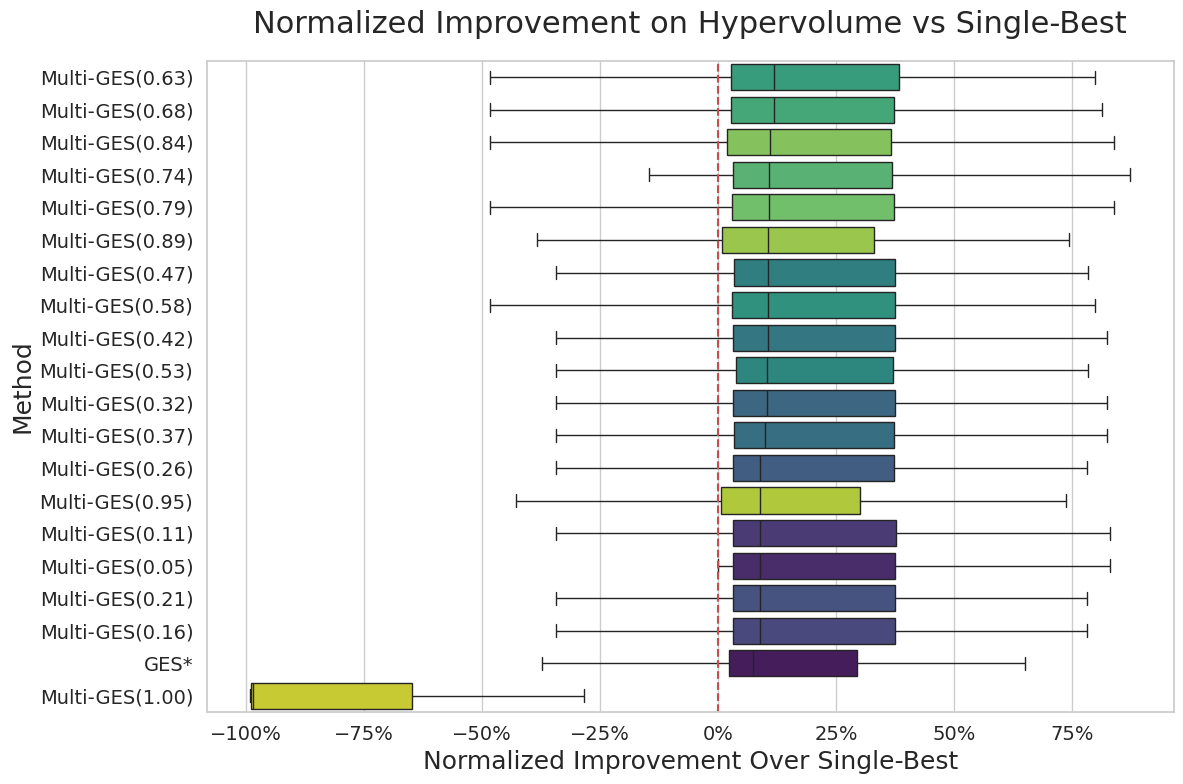

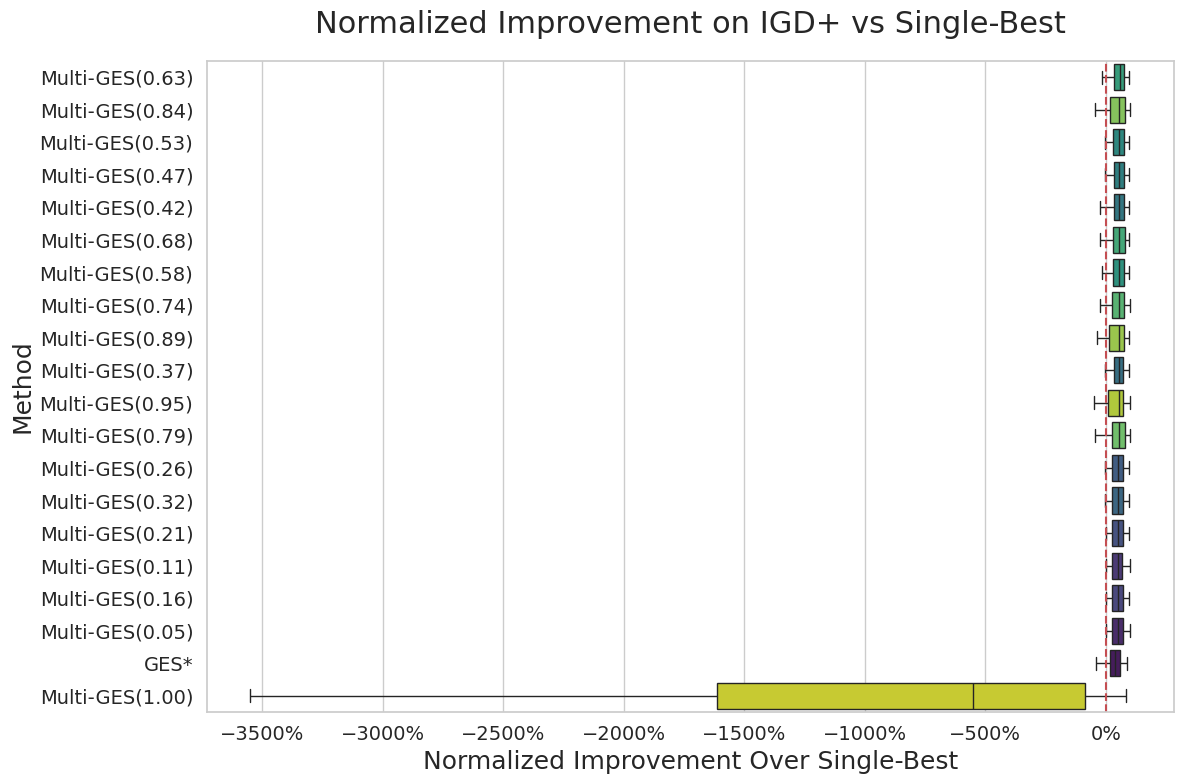

In [16]:
# --- Plot for Hypervolume ---
# Higher is better for Hypervolume, so we set higher_is_better=True
plot_normalized_improvement(
    df_scores=pivot_hypervolumes,
    baseline_method="Single-Best",
    higher_is_better=True,
    title="Normalized Improvement on Hypervolume vs Single-Best"
)

# --- Plot for IGD+ ---
# Lower is better for IGD+, so we set higher_is_better=False
plot_normalized_improvement(
    df_scores=igd_pivots,
    baseline_method="Single-Best",
    higher_is_better=False,
    title="Normalized Improvement on IGD+ vs Single-Best"
)

### Pareto Front Topography

/tmp/ipykernel_53796/3245435829.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby(['method_name', 'task_id', 'seed', 'fold']).size().reset_index(name='total_solutions')
/tmp/ipykernel_53796/3245435829.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_53796/3245435829.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


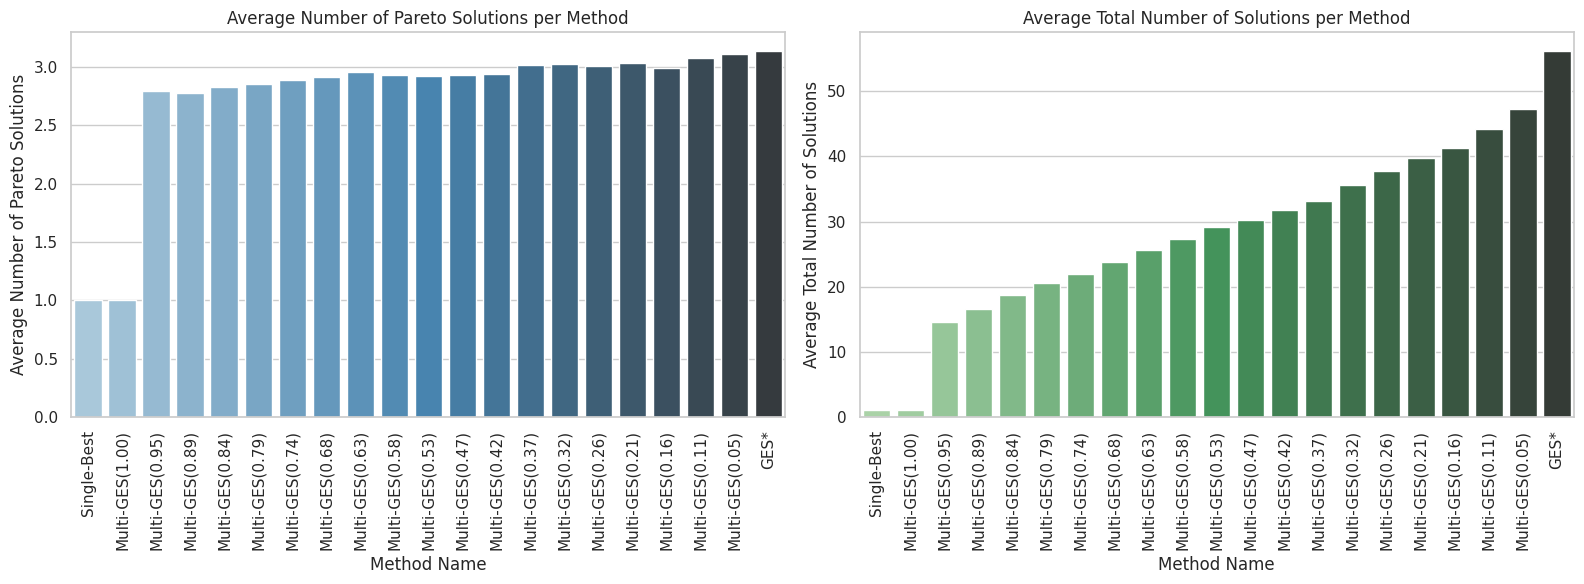

In [17]:
# Get unique method names
method_names = df["method_name"].unique()

# Calculate Pareto fronts for each method
method_pareto_fronts = {}
for method in method_names:
    df_method = df[df["method_name"] == method]
    method_pareto_fronts[method] = calculate_pareto_fronts(df_method, ['normalized_roc_auc_test', 'normalized_time'])

# Function to count the number of solutions in Pareto fronts
def count_pareto_solutions(pareto_fronts):
    counts = {}
    for task_id in pareto_fronts:
        for seed in pareto_fronts[task_id]:
            for fold in pareto_fronts[task_id][seed]:
                pareto_front_df = pareto_fronts[task_id][seed][fold]
                n_solutions = len(pareto_front_df)
                key = (task_id, seed, fold)
                counts[key] = n_solutions
    return counts

# Count solutions in the method-specific Pareto fronts
method_pareto_counts = {}
for method in method_names:
    method_pareto_counts[method] = count_pareto_solutions(method_pareto_fronts[method])

# Calculate total number of solutions per method, task_id, seed, fold
total_counts = df.groupby(['method_name', 'task_id', 'seed', 'fold']).size().reset_index(name='total_solutions')

# Prepare data for plotting counts
data_list = []

# Add the method-specific Pareto fronts and total counts
for method in method_names:
    counts = method_pareto_counts[method]
    for key, n_solutions in counts.items():
        task_id, seed, fold = key
        # Get total number of solutions for this method, task_id, seed, fold
        total_solutions = total_counts[
            (total_counts['method_name'] == method) &
            (total_counts['task_id'] == task_id) &
            (total_counts['seed'] == seed) &
            (total_counts['fold'] == fold)
        ]['total_solutions'].values[0]
        data_list.append({
            'method_name': method,
            'task_id': task_id,
            'seed': seed,
            'fold': fold,
            'n_pareto_solutions': n_solutions,
            'total_solutions': total_solutions
        })

pareto_counts_df = pd.DataFrame(data_list)
pareto_counts_df['proportion_pareto'] = pareto_counts_df['n_pareto_solutions'] / pareto_counts_df['total_solutions']


# Calculate the average number of Pareto solutions per method
avg_pareto_solutions = pareto_counts_df.groupby('method_name')['n_pareto_solutions'].mean().reset_index()

# Calculate the average total number of solutions per method
avg_total_solutions = pareto_counts_df.groupby('method_name')['total_solutions'].mean().reset_index()

# Merge the averages into a single DataFrame
avg_counts_df = pd.merge(avg_pareto_solutions, avg_total_solutions, on='method_name')

# Sort methods by average total solutions for better visualization
avg_counts_df = avg_counts_df.sort_values('total_solutions')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot average number of Pareto solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='n_pareto_solutions',
    ax=axes[0],
    palette='Blues_d'
)
axes[0].set_title('Average Number of Pareto Solutions per Method')
axes[0].set_xlabel('Method Name')
axes[0].set_ylabel('Average Number of Pareto Solutions')
axes[0].tick_params(axis='x', rotation=90)

# Plot average total number of solutions
sns.barplot(
    data=avg_counts_df,
    x='method_name',
    y='total_solutions',
    ax=axes[1],
    palette='Greens_d'
)
axes[1].set_title('Average Total Number of Solutions per Method')
axes[1].set_xlabel('Method Name')
axes[1].set_ylabel('Average Total Number of Solutions')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig("../plots/avg_good_pareto_vs_total_ensembles.png", dpi=300)
plt.savefig("../plots/avg_good_pareto_vs_total_ensembles.pdf", dpi=300)
plt.show()

### Proportion of Solutions on the Global Pareto Front

The following plot illustrates the effectiveness of each method in generating solutions that are part of the global Pareto front. For each task, the global Pareto front is determined by considering all solutions from all methods. We then calculate the proportion of each method's generated solutions that lie on this global front. A higher proportion indicates that a method is more efficient at finding globally optimal solutions.

Preparing data for per-task and per-seed analysis...
Averaging the per-task-seed results...
Generating the final plot...


/tmp/ipykernel_53796/1852411505.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_yticklabels)


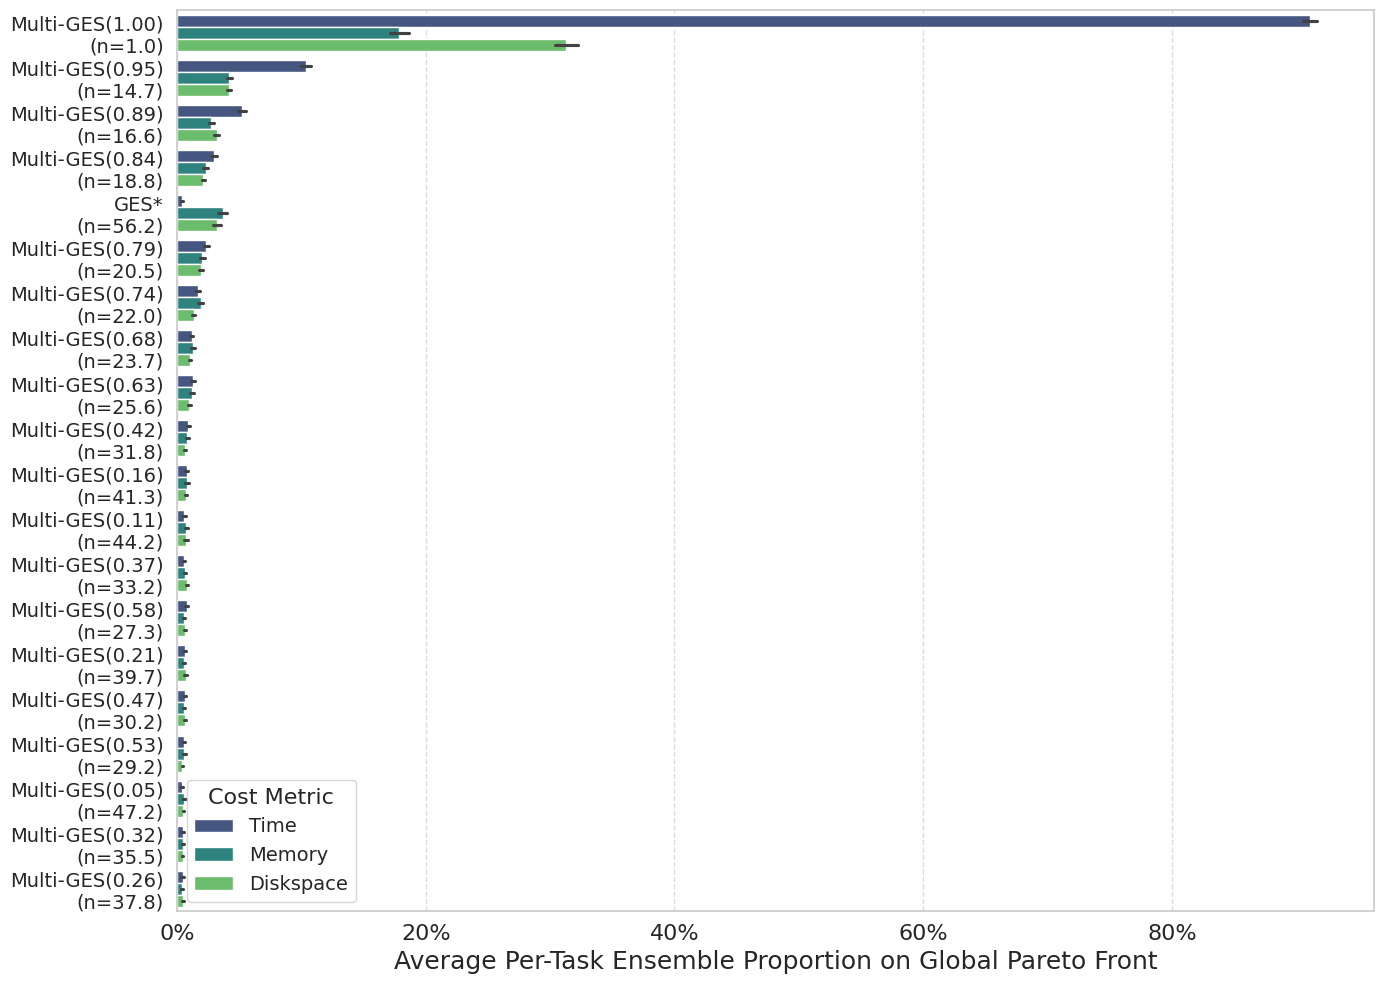

In [18]:
import matplotlib.ticker as mtick

print("Preparing data for per-task and per-seed analysis...")
df_main = df.copy()
task_column_name = 'task'

cost_metrics = ['normalized_time', 'normalized_memory', 'normalized_diskspace']
unique_tasks = df_main[task_column_name].unique()
unique_seeds = df_main['seed'].unique()
all_proportions = []

# Loop over each task
for task in unique_tasks:
    # --- CHANGE: Added inner loop to iterate over each seed ---
    for seed in unique_seeds:
        # Filter for the specific task and seed combination
        df_task_seed = df_main[(df_main[task_column_name] == task) & (df_main['seed'] == seed)].copy()

        # If there's no data for this combination, skip to the next
        if df_task_seed.empty:
            continue

        # Get total solutions for this specific task-seed combo
        total_solutions_task_seed = df_task_seed.groupby('method_name', observed=True).size()

        for metric in cost_metrics:
            objectives = ['normalized_roc_auc_test', metric]
            pf_col_name = f'is_on_pf_{metric}'
            df_task_seed[pf_col_name] = False

            # Calculate Pareto front for each fold within this task and seed
            global_pareto_indices = []
            # --- CHANGE: Grouping is now only by 'fold' ---
            for name, group in df_task_seed.groupby(['fold']):
                if not group.empty:
                    is_efficient_mask = getParetoFront(group, objectives, return_mask=True)
                    global_pareto_indices.extend(group[is_efficient_mask].index)

            # Ensure we only use unique indices
            df_task_seed.loc[list(set(global_pareto_indices)), pf_col_name] = True

            # Calculate proportions for each method within this task-seed combo
            solutions_on_pf = df_task_seed.groupby('method_name', observed=True)[pf_col_name].sum()
            task_seed_proportions = (solutions_on_pf / total_solutions_task_seed).fillna(0)

            # Store the results for this task-seed combo
            for method_name, proportion in task_seed_proportions.items():
                all_proportions.append({
                    task_column_name: task,
                    'seed': seed, # Also store the seed
                    'method_name': method_name,
                    'metric_type': metric.replace('_', ' ').replace('normalized', '').strip().capitalize(),
                    'proportion': proportion,
                    'num_solutions': total_solutions_task_seed.get(method_name, 0)
                })

print("Averaging the per-task-seed results...")
per_task_seed_df = pd.DataFrame(all_proportions)

# Filter out the 'Single-Best' method if it exists
if 'Single-Best' in per_task_seed_df['method_name'].unique():
    per_task_seed_df = per_task_seed_df[per_task_seed_df['method_name'] != 'Single-Best']

# Forcefully remove the unused 'Single-Best' category to fix plotting issues
if isinstance(per_task_seed_df['method_name'].dtype, pd.CategoricalDtype):
    per_task_seed_df['method_name'] = per_task_seed_df['method_name'].cat.remove_unused_categories()

# Determine the final sort order based on the new, more granular mean
sort_order_df = per_task_seed_df.groupby('method_name', observed=True)['proportion'].mean().sort_values(ascending=False)
sort_order = sort_order_df.index.tolist()
# Note: n is now the average number of solutions per task-seed combination
avg_solutions_per_method = per_task_seed_df.groupby('method_name')['num_solutions'].mean()

print("Generating the final plot...")
plt.figure(figsize=(14, 10))
ax = sns.barplot(
    data=per_task_seed_df,
    y='method_name',
    x='proportion',
    hue='metric_type',
    order=sort_order,
    palette='viridis',
    errorbar='se'
)

new_yticklabels = []
for method in sort_order:
    avg_sol = avg_solutions_per_method.get(method, 0)
    # The label now reflects that 'n' is the avg per task-seed run
    new_yticklabels.append(f"{method}\n(n={avg_sol:.1f})")

ax.set_yticklabels(new_yticklabels)

# Apply formatting
ax.set_xlabel('Average Per-Task Ensemble Proportion on Global Pareto Front', fontsize=18)
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.legend(title='Cost Metric', fontsize=14, title_fontsize=16)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

directory = "../plots"
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig(f"{directory}/proportion_on_global_pf_per_task_seed_avg.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{directory}/proportion_on_global_pf_per_task_seed_avg.pdf", dpi=300, bbox_inches="tight")

plt.show()

## Ensemble Construction Behavior

Dataset is large. Using a random sample of 300000 points for speed.
Generating final polished density plots...


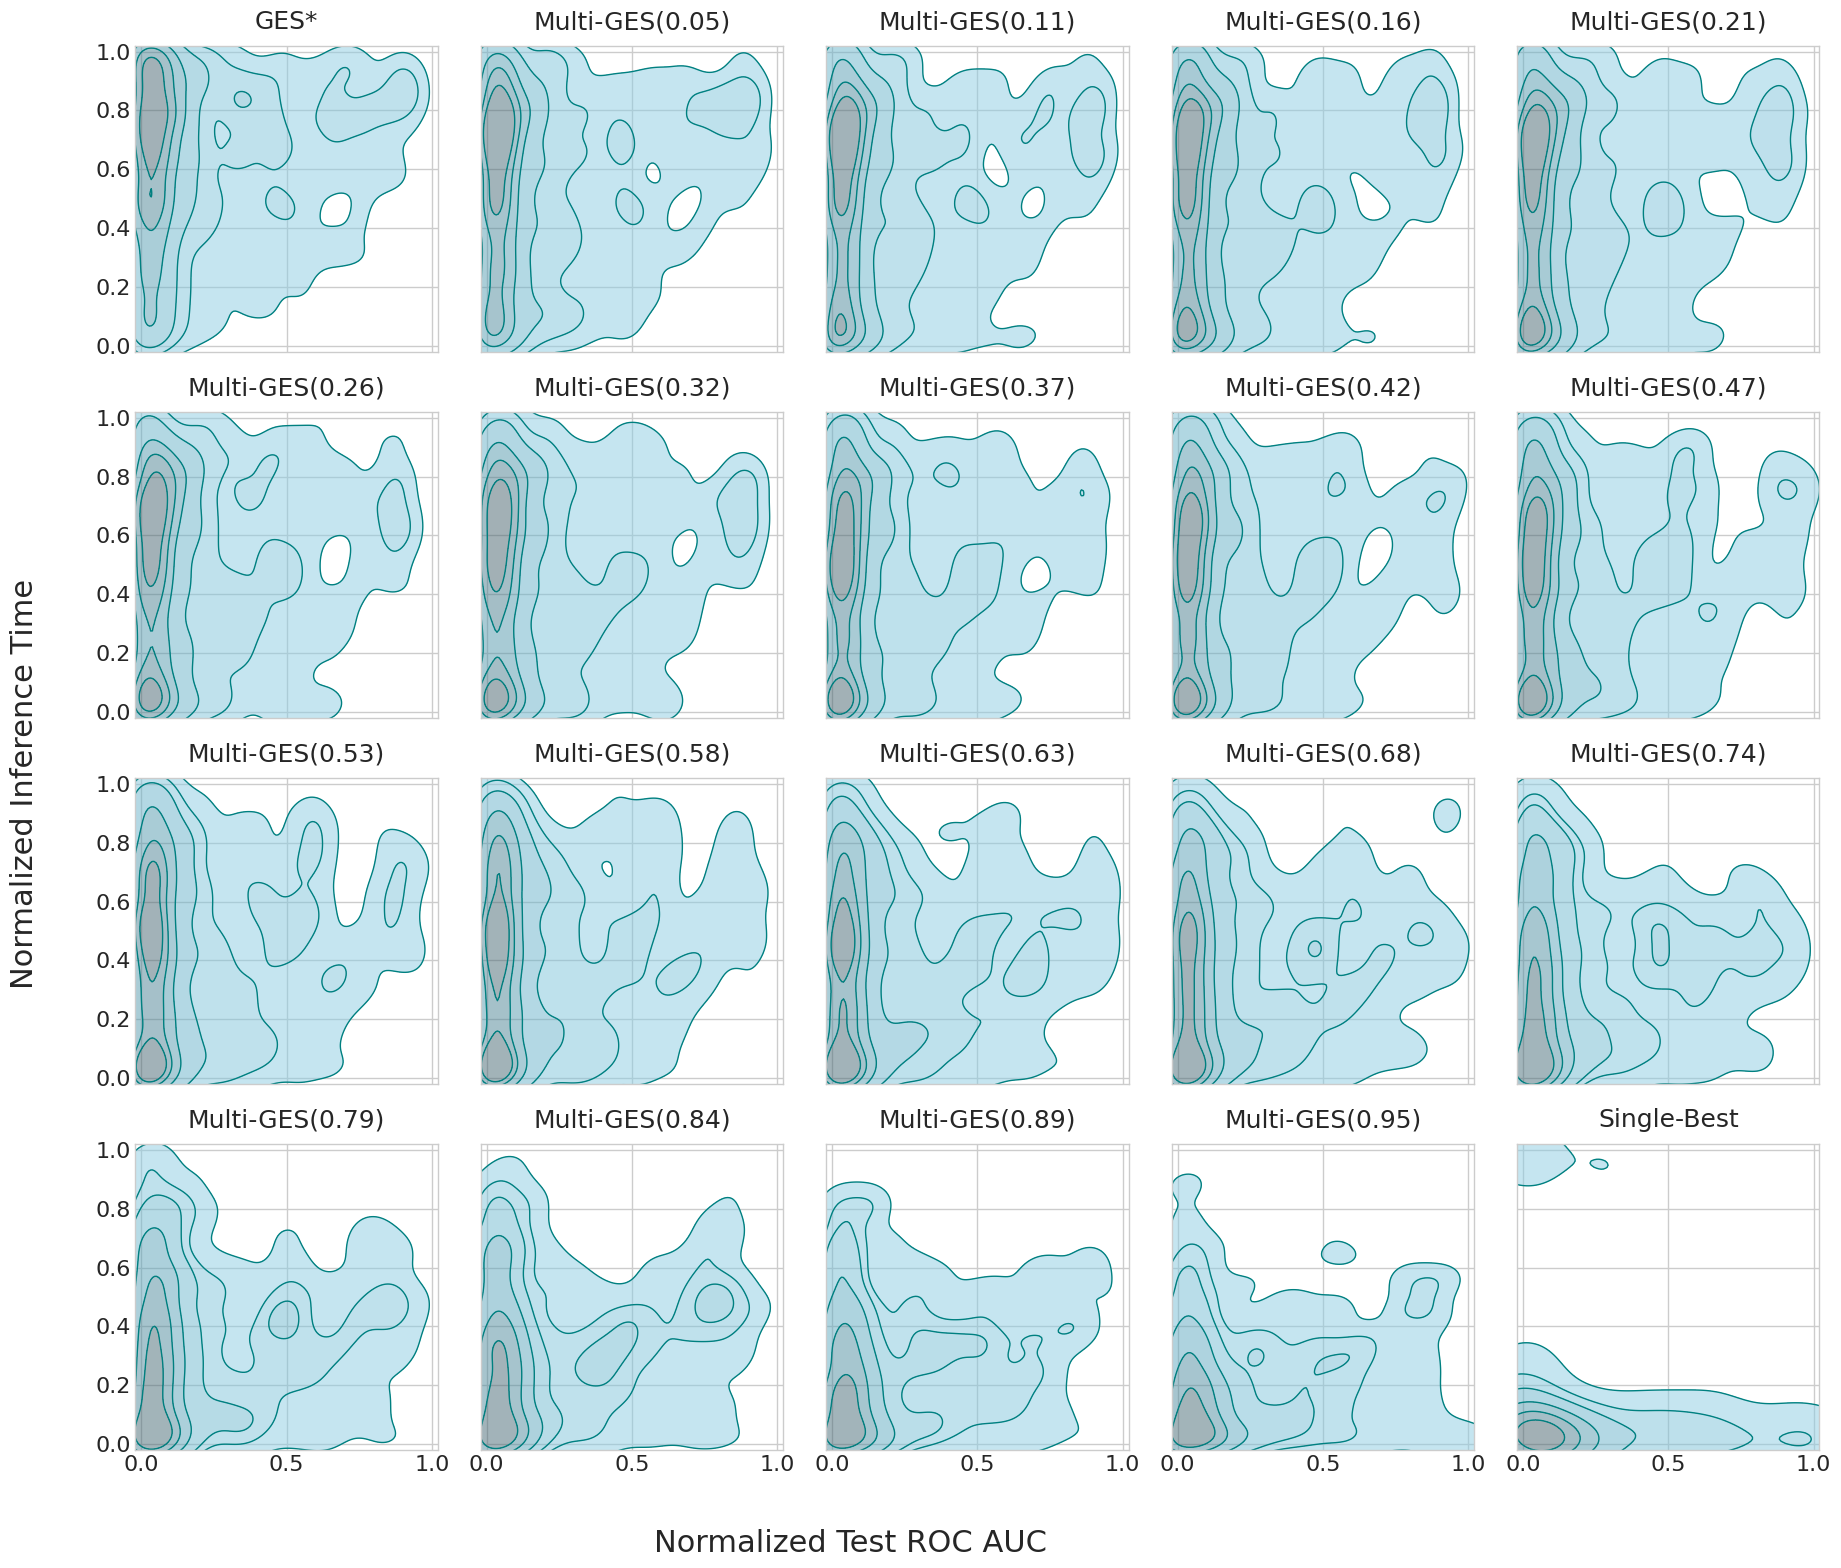

In [23]:
objectives_to_plot = ['normalized_roc_auc_test', 'normalized_time']

# --- Performance: Subsample the data ---
n_samples = 300000
df = df[df['method_name'] != 'Multi-GES(1.00)']
if len(df) > n_samples:
    print(f"Dataset is large. Using a random sample of {n_samples} points for speed.")
    df_sample = df.sample(n=n_samples, random_state=42)
else:
    df_sample = df

# --- Subplot Grid Setup ---
method_names = sorted(df_sample['method_name'].unique()) # Sort names for consistent order
num_methods = len(method_names)

grid_cols = math.ceil(math.sqrt(num_methods))
grid_rows = math.ceil(num_methods / grid_cols)

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(
    grid_rows, 
    grid_cols, 
    figsize=(20, 18), 
    sharex=True, 
    sharey=True
)
axes = axes.flatten()

print("Generating final polished density plots...")

# --- Loop through each method and create its subplot ---
for i, method in enumerate(method_names):
    ax = axes[i]
    df_method_sample = df_sample[df_sample['method_name'] == method]
    
    sns.kdeplot(
        data=df_method_sample,
        x=objectives_to_plot[0],
        y=objectives_to_plot[1],
        fill=True,
        alpha=0.5,
        color='c',
        levels=7,
        ax=ax
    )
    
    sns.kdeplot(
        data=df_method_sample,
        x=objectives_to_plot[0],
        y=objectives_to_plot[1],
        fill=False,
        linewidths=1.0,
        color='teal',
        levels=7,
        ax=ax
    )
    
    ax.set_title(method, fontsize=18, pad=12)

# --- Final Touches ---
for i in range(num_methods, len(axes)):
    ax = axes[i]
    ax.set_frame_on(False) # Make frame invisible
    ax.get_yaxis().set_visible(False) # Hide Y axis objects
    ax.spines['bottom'].set_visible(False) # Hide the x-axis line
    ax.tick_params(bottom=False) # Hide the x-axis tick marks

# Set common labels and a title for the entire figure
fig.supxlabel('Normalized Test ROC AUC', fontsize=22, y=0.07)
fig.supylabel('Normalized Inference Time', fontsize=22, x=0.08)

# --- CHANGE: Add buffer to xlim/ylim to fix overlapping zero labels ---
plt.setp(axes, xlim=(-0.02, 1.02), ylim=(-0.02, 1.02))

# Increase tick label size and clear individual labels
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=16)

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0.09, 0.08, 1, 0.94])

plt.savefig("../plots/density_plot.png", dpi=300)
plt.savefig("../plots/density_plot.pdf", dpi=300)
plt.show()

## Latex Table

In [20]:
def create_latex_table(df, repo, filename="table.tex", max_char=15):
    methods = df["method_name"].unique()
    task_ids = df["task_id"].unique()

    with open(filename, "w") as f:
        f.write("\\begin{longtable}{l" + "c" * len(methods) + "}\n")
        f.write(
            "\\caption{Test ROC AUC - Binary: The mean and standard deviation of the test score over all folds for each method. The best methods per dataset are shown in bold. All methods close to the best method are considered best (using NumPy’s default \\texttt{isclose} function).}\n"
        )
        f.write("\\label{tab:results} \\\\ \n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endfirsthead\n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endhead\n")
        f.write("\\midrule\n")
        f.write(
            "\\multicolumn{"
            + str(len(methods) + 1)
            + "}{r}{Continued on next page} \\\\\n"
        )
        f.write("\\midrule\n")
        f.write("\\endfoot\n")
        f.write("\\bottomrule\n")
        f.write("\\endlastfoot\n")

        for task_id in task_ids:
            dataset_name = repo.tid_to_dataset(
                task_id
            )  # Convert task_id to dataset name
            truncated_name = (
                (dataset_name[:max_char] + "...")
                if len(dataset_name) > max_char
                else dataset_name
            )
            escaped_name = truncated_name.replace("_", "\\_")  # Escape underscores
            line = [str(escaped_name)]  # Ensure the first item is a string
            method_scores = []

            for method in methods:
                method_data = df[
                    (df["task_id"] == task_id) & (df["method_name"] == method)
                ]
                if not method_data.empty:
                    mean_score = method_data["roc_auc_test"].mean()
                    std_dev = method_data["roc_auc_test"].std()
                    score_str = f"{mean_score:.4f}($\\pm${std_dev:.4f})"
                    method_scores.append((mean_score, score_str))
                else:
                    method_scores.append((None, "-"))

            # Determine the best score
            best_score = max(
                score[0] for score in method_scores if score[0] is not None
            )

            for mean_score, score_str in method_scores:
                if mean_score is not None and np.isclose(mean_score, best_score):
                    line.append(f"\\textbf{{{score_str}}}")
                else:
                    line.append(score_str)

            f.write(" & ".join(line) + " \\\\\n")

        f.write("\\bottomrule\n")
        f.write("\\end{longtable}\n")

In [21]:
directory = "../tables"
if not os.path.exists(directory):
    os.makedirs(directory)

repo = load_repository("D244_F3_C1530_100", cache=True)
create_latex_table(df, repo, filename="../tables/table.tex")